<a href="https://colab.research.google.com/github/dhy02094/STUDY_TH/blob/master/%EC%9D%8C%EC%84%B1%EC%A0%84%EC%B2%98%EB%A6%AC%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchaudio

# 필요 라이브러리 불러오기

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd

# DATA 불러오기

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url='train-clean-100', download=True)

In [ ]:
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url='test-clean', download=True)

  0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
test_dataset[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [ ]:
train_dataset[1]

(tensor([[-0.0059, -0.0045, -0.0067,  ...,  0.0007,  0.0034,  0.0047]]),
 16000,
 "THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE BUT BY THE TIME IT REACHED LYNDE'S HOLLOW IT WAS A QUIET WELL CONDUCTED LITTLE STREAM",
 103,
 1240,
 1)

In [ ]:
test_dataset[1][0].shape

torch.Size([1, 52400])

# 샘플링(sampling)

## sampling
- 음성을을 처리하기기 위해해 아날로그그 정보를를 잘게게 쪼개 이산적인인 디지털 정보로 표현현

- sampling rate
    - 얼마나 잘게 조갤지 결정
    - 잘게게 쪼갤수록록 정보손실이이 줄어들지만, 데이터의 크기가 늘어남
    - sampling rate가 최대 frequency보다다 2배배 커져야함

In [14]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data,sr)
print('length:', len(audio_data))
print('duration:', len(audio_data) / sr)

ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


In [15]:
# Resampling 

# smpaling data의의 sampling rate를 조정해 다시 sampling 하는것

audio_np = audio_data.numpy()
y_8k = librosa.resample(audio_np, sr, 8000)

print('length:', len(y_8k))

ipd.Audio(y_8k, rate=8000)


length: 26200


In [18]:
audio_np = audio_data.numpy()
y_4k = librosa.resample(audio_np, sr, 4000)

print('length:', len(y_4k))

ipd.Audio(y_4k, rate=4000)


length: 13100


> 점점 소리가 통화하는 것처럼 들려진다.

## Normalization & Quantization

In [19]:
audio_np = audio_data.numpy()

# 최대값을 나눠준다.
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [20]:
bit = 8
max_value = 2 ** (bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

# 퓨리에 변환

- 오일러 공식으로 지수함수와 주기 함수간 관계를 나타낼수 있음

- 결국 어떤 입력신호가 와도 sin, cos 같은 주기 함수들의 합으로 분해가 가능함

## 이산 퓨리에 변환(DFT)

- 샘플링한 데이터 자체가 discrete data
- 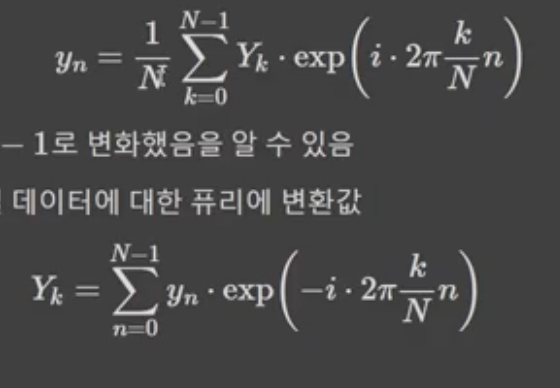

## STFT

- 시간에 흐름에 따라 분석

- N : FFT size
    - window를 얼마나 많은 주파수 밴드로 나누는가

- 440Hz 신호의 window size는 5 *(1/440)
- T(Window) = 5T(signal), duration은 신호주기보다 5배이상 길게 잡아야한다

- n : window size
    - window함수에 들어가는 샘플의 양
    - 작을수록 low-frequency resolution, higt-time resolution

- H : hop size
    - 윈도우가 겹치는 사이즈, 일반적으로는 1/4 정도를 겹치게 함

- STFT의 결과는 즉 시간의 흐름(WINDOW)에 따른 Frequency 영역별 Amplitude를 반환

In [22]:
print(audio_np.shape, sr)

(52400,) 16000


In [23]:
s = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
print(s.shape, len(s[0]), s[0][0])


(513, 103) 103 (0.044214446+0j)


In [24]:
d = np.abs(s) ** 2
print(d.shape)

(513, 103)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


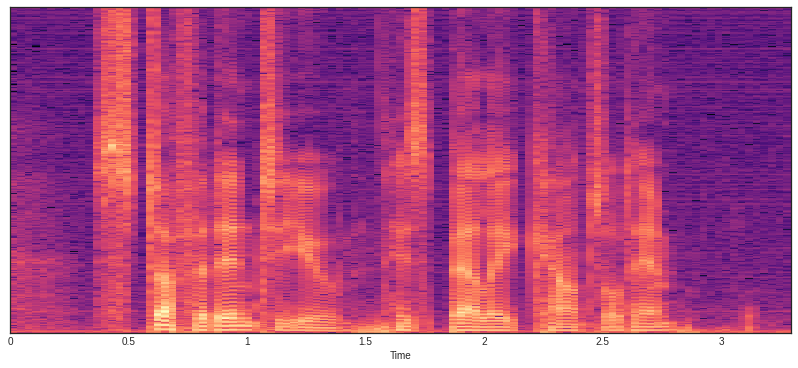

In [25]:
log_s = librosa.power_to_db(s, ref=np.max)

plt.figure(figsize=(14,6))
librosa.display.specshow(log_s, sr=16000, x_axis='time')

> stft 해서 변환한 그림

In [26]:
mel_basis = librosa.filters.mel(sr, n_fft=1024, n_mels=40)
mel_s = np.dot(mel_basis, d)
print(mel_s.shape)

(40, 103)


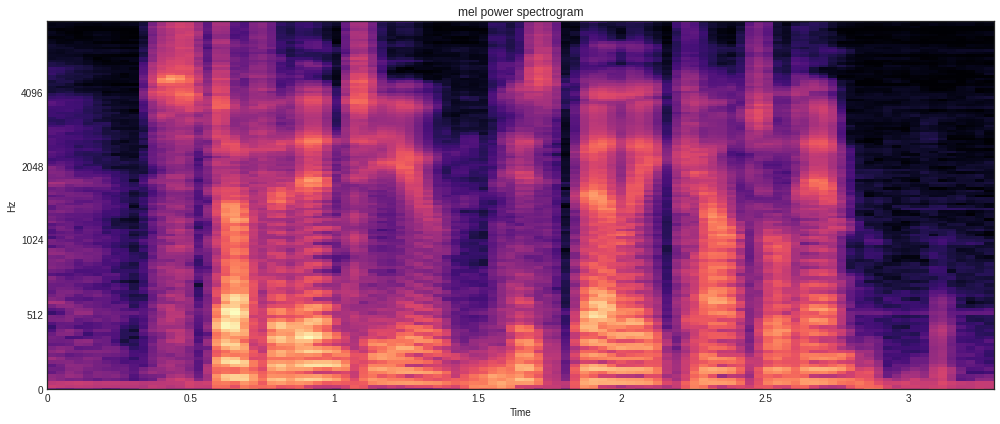

In [28]:
s = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=128)
log_s = librosa.power_to_db(s, ref=np.max)

plt.figure(figsize=(14,6))
librosa.display.specshow(log_s, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.tight_layout()